### Simple RFM and Cohort analysis

Description: RFM Analysis on a simple e-commerce dataset
using kaggle data <br>
This notebook is based on towardsdatascience  <br>
post: https://towardsdatascience.com/customer-segmentation-in-online-retail-1fc707a6f9e6

Dataset: https://www.kaggle.com/carrie1/ecommerce-data

In [1]:
# Importing standard libraries

import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns

from sklearn import preprocessing
import sklearn
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
#from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from matplotlib import pyplot as plt

## Reading data and preprocessing

In [2]:
df = pd.read_csv('./data/e-commerce_data(kaggle).csv',encoding="ISO-8859-1",dtype={'CustomerID': str,'InvoiceID': str})
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],format=("%m/%d/%Y %H:%M"))
#df = pd.read_excel('/Users/rahulkhandelwal/Desktop/Code/customer_segmentation/customer_segmentation/Online Retail.xlsx')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [4]:
df.shape

(541909, 8)

Removing duplicate entries.

In [5]:
print('Duplicate entries: {}'.format(df.duplicated().sum()))
print('{}% rows are duplicate.'.format(round((df.duplicated().sum()/df.shape[0])*100),2))
df.drop_duplicates(inplace = True)

Duplicate entries: 5268
1% rows are duplicate.


Checking the total number of products, transactions and customers.

In [6]:
pd.DataFrame([{'products': len(df['StockCode'].value_counts()),    
               'transactions': len(df['InvoiceNo'].value_counts()),
               'customers': len(df['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,4070,25900,4372


Checking country wise distribution of transactions.

In [7]:
temp = df.groupby(['Country'],as_index=False).agg({'InvoiceNo':'nunique'}).rename(columns = {'InvoiceNo':'Orders'})
total = temp['Orders'].sum(axis=0)
temp['%Orders'] = round((temp['Orders']/total)*100,4)

In [8]:
temp.sort_values(by=['%Orders'],ascending=False,inplace=True)
temp.reset_index(drop=True,inplace=True)

Text(0, 0.5, '%Orders')

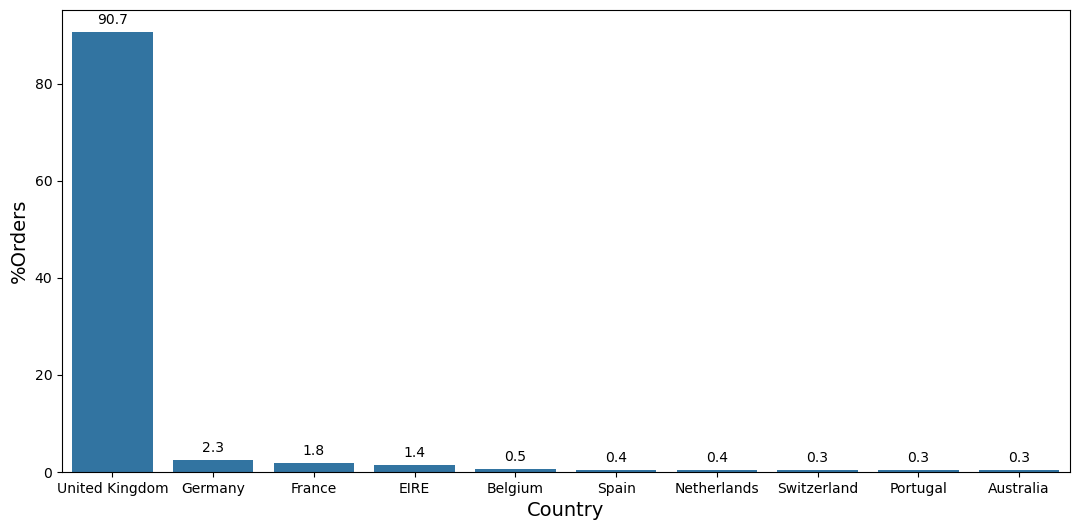

In [9]:
plt.figure(figsize=(13,6))
splot=sns.barplot(x="Country",y="%Orders",data=temp[:10])
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Country", size=14)
plt.ylabel("%Orders", size=14)

Removing cancelled orders from the data.

In [10]:
invoices = df['InvoiceNo']

In [11]:
x = invoices.str.contains('C', regex=True)
x.fillna(0, inplace=True)

In [12]:
x = x.astype(int)

In [13]:
x.value_counts()

InvoiceNo
0    527390
1      9251
Name: count, dtype: int64

In [14]:
df['order_canceled'] = x
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_canceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0


In [15]:
df['order_canceled'].value_counts()

order_canceled
0    527390
1      9251
Name: count, dtype: int64

In [16]:
n1 = df['order_canceled'].value_counts()[1]
n2 = df.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

Number of orders canceled: 9251/536641 (1.72%) 


In [17]:
df = df.loc[df['order_canceled'] == 0,:]

In [18]:
df.reset_index(drop=True,inplace=True)

Checking if we have negative quantities against any InvoiceNo.

In [19]:
df.loc[df['Quantity'] < 0,:]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_canceled
2336,536589,21777,NaN,-10,2010-12-01 16:50:00,0.0,NaN,United Kingdom,0
4249,536764,84952C,NaN,-38,2010-12-02 14:42:00,0.0,NaN,United Kingdom,0
7003,536996,22712,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom,0
7004,536997,22028,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom,0
7005,536998,85067,NaN,-6,2010-12-03 15:30:00,0.0,NaN,United Kingdom,0
...,...,...,...,...,...,...,...,...,...
520928,581210,23395,check,-26,2011-12-07 18:36:00,0.0,NaN,United Kingdom,0
520930,581212,22578,lost,-1050,2011-12-07 18:38:00,0.0,NaN,United Kingdom,0
520931,581213,22576,check,-30,2011-12-07 18:38:00,0.0,NaN,United Kingdom,0
522503,581226,23090,missing,-338,2011-12-08 09:56:00,0.0,NaN,United Kingdom,0


We find out that CustomerID values are missing for those customers which have negative quantity values. Therefore, we will remove them too.

In [20]:
df = df[df['CustomerID'].notna()]

In [21]:
df.reset_index(drop=True,inplace=True)

In [22]:
df_uk = df[df.Country == 'United Kingdom']

In [23]:
df_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_canceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0


In [24]:
df_uk.info()

<class 'pandas.core.frame.DataFrame'>
Index: 349227 entries, 0 to 392716
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   InvoiceNo       349227 non-null  object        
 1   StockCode       349227 non-null  object        
 2   Description     349227 non-null  object        
 3   Quantity        349227 non-null  int64         
 4   InvoiceDate     349227 non-null  datetime64[ns]
 5   UnitPrice       349227 non-null  float64       
 6   CustomerID      349227 non-null  object        
 7   Country         349227 non-null  object        
 8   order_canceled  349227 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(5)
memory usage: 25.3+ MB


In [25]:
pd.DataFrame([{'products': len(df['StockCode'].value_counts()),    
               'transactions': len(df['InvoiceNo'].value_counts()),
               'customers': len(df['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3665,18536,4339


## Cohort Analysis 

What is Cohort Analysis?

A cohort is a set of users who share similar characteristics over time. Cohort analysis groups the users into mutually exclusive groups and their behaviour is measured over time.

It can provide information about product and customer lifecycle.

There are three types of cohort analysis: 
1. Time cohorts: It groups customers by their purchase behaviour over time.
2. Behaviour cohorts: It groups customers by the product or service they signed up for.
3. Size cohorts: Refers to various sizes of customers who purchase company's products or services. This categorization can be based on the amount of spending in some period of time.

Understanding the needs of various cohorts can help a company design custom-made services or products for particular segments.

In the following analysis, we will create Time cohorts and look at customers who remain active during particular cohorts over a period of time that they transact over.

In [26]:
cohort_data = df_uk[['InvoiceNo','StockCode','Description','Quantity','InvoiceDate','UnitPrice','CustomerID','Country']]

In [27]:
# Checking for nulls in the data.
cohort_data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [28]:
all_dates = (pd.to_datetime(cohort_data['InvoiceDate'])).apply(lambda x:x.date())

Let us check the date range of our data.

In [29]:
(all_dates.max() - all_dates.min()).days

373

In [30]:
# Start and end dates:
print('Start date: {}'.format(all_dates.min()))
print('End date: {}'.format(all_dates.max()))

Start date: 2010-12-01
End date: 2011-12-09


In [31]:
cohort_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [32]:
def get_month(x):
    return dt.datetime(x.year, x.month, 1)

#cohort_data['InvoiceMonth'] = cohort_data['InvoiceDate'].dt.strftime('%Y-%m-%d').apply(get_month)
cohort_data['InvoiceMonth'] = cohort_data['InvoiceDate'].apply(get_month)
cohort_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01
...,...,...,...,...,...,...,...,...,...
392712,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804,United Kingdom,2011-12-01
392713,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113,United Kingdom,2011-12-01
392714,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113,United Kingdom,2011-12-01
392715,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113,United Kingdom,2011-12-01


In [33]:


cohort_data['InvoiceMonth'] = cohort_data['InvoiceMonth'].dt.strftime('%Y-%m-%d')
grouping = cohort_data.groupby('CustomerID')['InvoiceMonth']
cohort_data['CohortMonth'] = grouping.transform('min')
cohort_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01


In [34]:
cohort_data['InvoiceMonth'] = pd.to_datetime(cohort_data['InvoiceMonth'],format=("%Y-%m-%d"))
cohort_data['CohortMonth'] = pd.to_datetime(cohort_data['CohortMonth'],format=("%Y-%m-%d"))
cohort_data.dtypes

InvoiceNo               object
StockCode               object
Description             object
Quantity                 int64
InvoiceDate     datetime64[ns]
UnitPrice              float64
CustomerID              object
Country                 object
InvoiceMonth    datetime64[ns]
CohortMonth     datetime64[ns]
dtype: object

In [35]:
def get_date_int(df, column):    
    year = df[column].dt.year    
    month = df[column].dt.month    
    day = df[column].dt.day
    return year, month, day


In [36]:
invoice_year, invoice_month, _ = get_date_int(cohort_data, 'InvoiceMonth') 
cohort_year, cohort_month, _ = get_date_int(cohort_data, 'CohortMonth')
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month
cohort_data['CohortIndex'] = years_diff * 12 + months_diff
cohort_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,2010-12-01,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01,2010-12-01,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,0


In [37]:
grouping = cohort_data.groupby(['CohortMonth', 'CohortIndex'])
cohort_data1 = grouping['CustomerID'].apply(pd.Series.nunique)
cohort_data1 = cohort_data1.reset_index()
cohort_counts = cohort_data1.pivot(index='CohortMonth',columns='CohortIndex',values='CustomerID')
cohort_counts

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12-01,815.0,289.0,263.0,304.0,293.0,323.0,291.0,278.0,289.0,325.0,299.0,405.0,218.0
2011-01-01,358.0,76.0,93.0,84.0,119.0,99.0,90.0,87.0,108.0,117.0,127.0,43.0,NaN
2011-02-01,340.0,64.0,66.0,97.0,98.0,86.0,87.0,96.0,90.0,104.0,25.0,NaN,NaN
2011-03-01,419.0,64.0,109.0,83.0,94.0,69.0,111.0,96.0,119.0,38.0,NaN,NaN,NaN
2011-04-01,277.0,58.0,56.0,60.0,56.0,61.0,61.0,73.0,20.0,NaN,NaN,NaN,NaN
2011-05-01,256.0,48.0,44.0,44.0,53.0,58.0,68.0,23.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,214.0,38.0,31.0,51.0,51.0,69.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,169.0,30.0,33.0,39.0,47.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,141.0,32.0,32.0,34.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


What does this tell us?

Consider CohortMonth 2010-12-01: For CohortIndex 0, this tells us that 815 unique customers made transactions during CohortMonth 2010-12-01. For CohortIndex 1, this tells that there are 289 customers out of 815 who made their first transaction during CohortMonth 2010-12-01 and they also made transactions during the next month. That is, they remained active. For CohortIndex 2, this tells that there are 263 customers out of 815 who made their first transaction during CohortMonth 2010-12-01 and they also made transactions during the second-next month. And so on for higher CohortIndices.

Let us now calculate the Retention Rate. It is defined as the percentage of active customers out of total customers

In [38]:
cohort_sizes = cohort_counts.iloc[:,0]

# Divide all values in the cohort_counts table by cohort_sizes
retention = cohort_counts.divide(cohort_sizes, axis=0)

# Review the retention table
retention.round(3) * 100
retention

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12-01,1.0,0.354601,0.322699,0.373006,0.359509,0.396319,0.357055,0.341104,0.354601,0.398773,0.366871,0.496933,0.267485
2011-01-01,1.0,0.212291,0.259777,0.234637,0.332402,0.276536,0.251397,0.243017,0.301676,0.326816,0.354749,0.120112,NaN
2011-02-01,1.0,0.188235,0.194118,0.285294,0.288235,0.252941,0.255882,0.282353,0.264706,0.305882,0.073529,NaN,NaN
2011-03-01,1.0,0.152745,0.260143,0.198091,0.224344,0.164678,0.264916,0.229117,0.284010,0.090692,NaN,NaN,NaN
2011-04-01,1.0,0.209386,0.202166,0.216606,0.202166,0.220217,0.220217,0.263538,0.072202,NaN,NaN,NaN,NaN
2011-05-01,1.0,0.187500,0.171875,0.171875,0.207031,0.226562,0.265625,0.089844,NaN,NaN,NaN,NaN,NaN
2011-06-01,1.0,0.177570,0.144860,0.238318,0.238318,0.322430,0.098131,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,1.0,0.177515,0.195266,0.230769,0.278107,0.106509,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,1.0,0.226950,0.226950,0.241135,0.120567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The first month's retention rate is 100%. This is because the number of active customers in the first month is actually the size of the cohort.

We can also calculate other metrics like the average quantity for each cohort.

In [39]:
cohort_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,2010-12-01,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01,2010-12-01,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,0
...,...,...,...,...,...,...,...,...,...,...,...
392712,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804,United Kingdom,2011-12-01,2011-05-01,7
392713,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113,United Kingdom,2011-12-01,2010-12-01,12
392714,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113,United Kingdom,2011-12-01,2010-12-01,12
392715,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113,United Kingdom,2011-12-01,2010-12-01,12


In [40]:
grouping = cohort_data.groupby(['CohortMonth', 'CohortIndex'])
cohort_data1 = grouping['Quantity'].mean()
cohort_data1 = cohort_data1.reset_index()
average_quantity = cohort_data1.pivot(index='CohortMonth',columns='CohortIndex',values='Quantity')
average_quantity.round(1)
average_quantity

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12-01,11.363528,12.863370,13.931012,13.872916,13.343757,13.287995,14.274862,13.773035,16.144706,16.123957,16.672496,12.446232,14.462301
2011-01-01,18.080062,9.628663,9.442006,15.098384,10.089666,10.894436,13.554896,10.814691,10.757836,8.695507,8.592414,10.022152,NaN
2011-02-01,10.997248,14.049922,15.948747,12.122111,12.320763,11.928197,13.872105,13.721955,10.996767,12.542671,13.819477,NaN,NaN
2011-03-01,9.695935,11.430435,13.305280,10.086977,13.532950,12.837738,13.107456,14.062043,11.199703,9.734098,NaN,NaN,NaN
2011-04-01,10.068291,10.156757,9.720736,11.940795,11.863813,8.262323,9.873959,9.363861,7.477707,NaN,NaN,NaN,NaN
2011-05-01,10.657960,9.392857,14.841623,12.800244,11.045652,8.307816,10.816216,126.911243,NaN,NaN,NaN,NaN,NaN
2011-06-01,9.549744,14.785714,11.980276,12.738017,9.818008,8.891049,9.350254,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,10.145833,14.984576,6.572790,8.112313,5.778264,6.683406,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,9.393834,6.029240,5.028132,5.909297,6.558894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let us now visualize the retention rates by a heatmap.

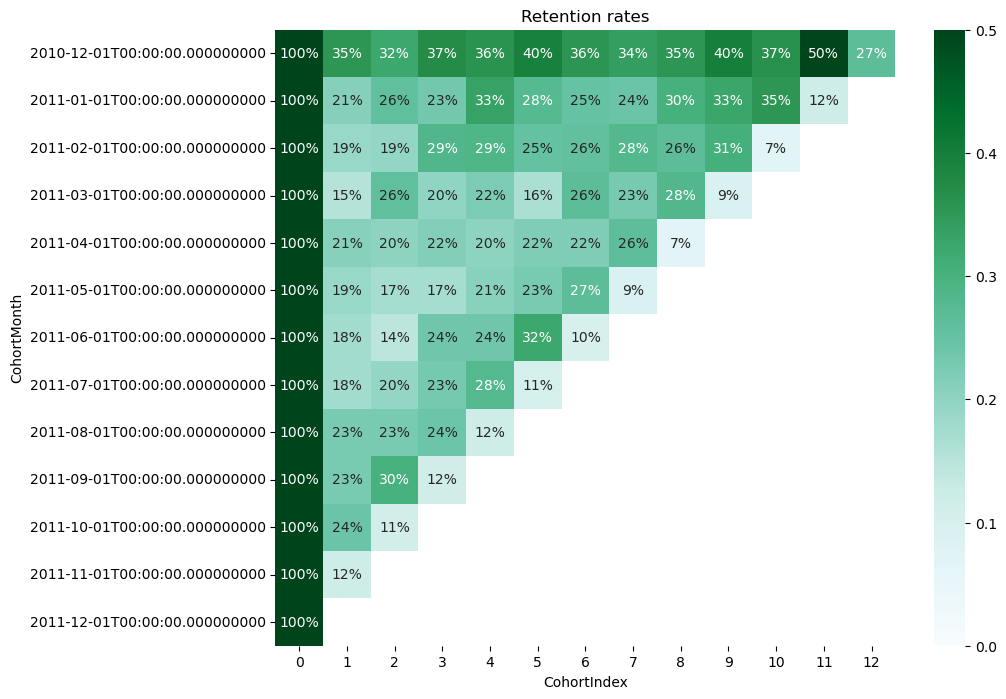

In [41]:
plt.figure(figsize=(10, 8))
plt.title('Retention rates')
sns.heatmap(data = retention,annot = True,fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap = 'BuGn')
plt.show()

## RFM Segmentation 

In [42]:
cohort_data['TotalSum'] = cohort_data['Quantity']*cohort_data['UnitPrice']
cohort_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex,TotalSum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,2010-12-01,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01,2010-12-01,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,0,20.34


Let us check the distribution of the TotalSum column to understand customer spending.

<Axes: >

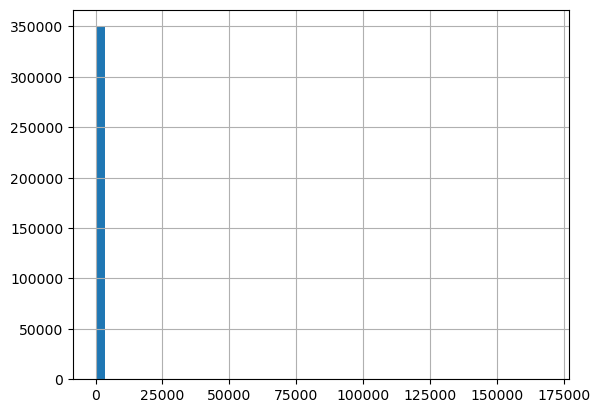

In [43]:
cohort_data.TotalSum.hist(bins=50)

In [44]:
cohort_data[['TotalSum']].describe()

,TotalSum
count,349227.000000
mean,20.860428
std,328.406035
min,0.000000
25%,4.200000
50%,10.200000
75%,17.850000
max,168469.600000


In [45]:
cohort_data[cohort_data['TotalSum']> 17.850000].sort_values('TotalSum',ascending=False)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex,TotalSum
392266,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom,2011-12-01,2011-05-01,7,168469.60
36527,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,2011-01-01,2011-01-01,0,77183.60
153601,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098,United Kingdom,2011-06-01,2011-06-01,0,38970.00
116879,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029,United Kingdom,2011-05-01,2010-12-01,5,8142.75
246062,567423,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,1412,2011-09-20 11:05:00,5.06,17450,United Kingdom,2011-09-01,2010-12-01,9,7144.72
...,...,...,...,...,...,...,...,...,...,...,...,...
65572,545081,22558,CLOTHES PEGS RETROSPOT PACK 24,12,2011-02-28 10:35:00,1.49,16057,United Kingdom,2011-02-01,2011-02-01,0,17.88
89499,547921,22558,CLOTHES PEGS RETROSPOT PACK 24,12,2011-03-28 13:28:00,1.49,14766,United Kingdom,2011-03-01,2010-12-01,3,17.88
65822,545150,22558,CLOTHES PEGS RETROSPOT PACK 24,12,2011-02-28 12:27:00,1.49,14227,United Kingdom,2011-02-01,2011-02-01,0,17.88
31685,540691,21673,WHITE SPOT BLUE CERAMIC DRAWER KNOB,12,2011-01-11 08:50:00,1.49,17450,United Kingdom,2011-01-01,2010-12-01,1,17.88


Let us check the max date and take data till a year behind the max date.

In [46]:
from dateutil.relativedelta import relativedelta
start_date = all_dates.max()-relativedelta(months=12,days=-1)
print('Start date: {}'.format(start_date))
print('End date: {}'.format(all_dates.max()))

Start date: 2010-12-10
End date: 2011-12-09


In [47]:
data_rfm = cohort_data[cohort_data['InvoiceDate'] >= pd.to_datetime(start_date)]
data_rfm.reset_index(drop=True,inplace=True)
data_rfm.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex,TotalSum
0,538172,21562,HAWAIIAN GRASS SKIRT,12,2010-12-10 09:33:00,1.25,15805,United Kingdom,2010-12-01,2010-12-01,0,15.0
1,538172,79321,CHILLI LIGHTS,8,2010-12-10 09:33:00,4.95,15805,United Kingdom,2010-12-01,2010-12-01,0,39.6
2,538172,22041,"RECORD FRAME 7"" SINGLE SIZE",12,2010-12-10 09:33:00,2.55,15805,United Kingdom,2010-12-01,2010-12-01,0,30.6
3,538172,84558A,3D DOG PICTURE PLAYING CARDS,12,2010-12-10 09:33:00,2.95,15805,United Kingdom,2010-12-01,2010-12-01,0,35.4
4,538172,22952,60 CAKE CASES VINTAGE CHRISTMAS,24,2010-12-10 09:33:00,0.55,15805,United Kingdom,2010-12-01,2010-12-01,0,13.2


In [48]:
snapshot_date = max(data_rfm.InvoiceDate) + dt.timedelta(days=1)
print('Snapshot date: {}'.format(snapshot_date.date()))

Snapshot date: 2011-12-10


In [49]:
# Aggregate data on a customer level
data = data_rfm.groupby(['CustomerID'],as_index=False).agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
                                             'InvoiceNo': 'count',
                                             'TotalSum': 'sum'}).rename(columns = {'InvoiceDate': 'Recency',
                                                                                   'InvoiceNo': 'Frequency',
                                                                                   'TotalSum': 'MonetaryValue'})

# Check the first rows
data.head()

,CustomerID,Recency,Frequency,MonetaryValue
0,12346,326,1,77183.60
1,12747,2,96,3837.45
2,12748,1,4055,31081.74
3,12749,4,199,4090.88
4,12820,3,59,942.34


In [50]:
r_labels = range(4, 0, -1)
r_quartiles = pd.qcut(data['Recency'], 4, labels = r_labels)
data = data.assign(R = r_quartiles.values)

f_labels = range(1,5)
m_labels = range(1,5)
f_quartiles = pd.qcut(data['Frequency'], 4, labels = f_labels)
m_quartiles = pd.qcut(data['MonetaryValue'], 4, labels = m_labels)
data = data.assign(F = f_quartiles.values)
data = data.assign(M = m_quartiles.values)
data.head()

,CustomerID,Recency,Frequency,MonetaryValue,R,F,M
0,12346,326,1,77183.60,1,1,4
1,12747,2,96,3837.45,4,3,4
2,12748,1,4055,31081.74,4,4,4
3,12749,4,199,4090.88,4,4,4
4,12820,3,59,942.34,4,3,3


In [51]:
def join_rfm(x):
    return str(x['R']) + str(x['F']) + str(x['M'])

data['RFM_Segment'] = data.apply(join_rfm, axis=1)
data['RFM_Score'] = data[['R','F','M']].sum(axis=1)
data.head()

,CustomerID,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
0,12346,326,1,77183.60,1,1,4,114,6
1,12747,2,96,3837.45,4,3,4,434,11
2,12748,1,4055,31081.74,4,4,4,444,12
3,12749,4,199,4090.88,4,4,4,444,12
4,12820,3,59,942.34,4,3,3,433,10


Let us now analyse RFM Score distribution and their groups.

In [52]:
data.groupby('RFM_Score').agg({'Recency': 'mean',
                                   'Frequency': 'mean',
                                   'MonetaryValue': ['mean', 'count'] }).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3           242.6       7.9         149.8   324
4           171.0      13.7         224.3   353
5           147.6      20.0         351.1   456
6            87.4      27.0         807.3   432
7            80.8      38.9         717.1   399
8            56.3      52.0         930.3   397
9            43.8      73.5        1757.9   373
10           32.0     110.4        1869.3   389
11           20.6     183.7        3405.9   334
12            6.9     351.9        8027.9   398

In [53]:
def create_segment(df):
    if df['RFM_Score'] >= 9:
        return 'Top'
    elif (df['RFM_Score'] >= 5) and (df['RFM_Score'] < 9):
        return 'Middle'
    else:
        return 'Low'
    
data['General_Segment'] = data.apply(create_segment, axis=1)
data.groupby('General_Segment').agg({'Recency': 'mean',
                                         'Frequency': 'mean',
                                         'MonetaryValue': ['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
Low               205.3      10.9         188.7   677
Middle             94.8      33.8         691.4  1684
Top                25.7     181.9        3825.7  1494

## Preprocessing data for Clustering 

In the next section, we are going to prepare the data for Kmeans clustering on RFM Score data. To do this, we need to preprocess the data so that it can meet the key assumptions of Kmeans algorithm, which are:

1. The varaiables should be distributed symmetrically
2. Variables should have similar average values
3. Variables should have similar standard deviation values

C:\Users\USER\AppData\Local\Temp\ipykernel_34400\618069177.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 2); sns.distplot(data['Frequency'])
C:\Users\USER\AppData\Local\Temp\ipykernel_34400\618069177.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 3); sns.distplot(data['Mone

<Axes: xlabel='MonetaryValue', ylabel='Density'>

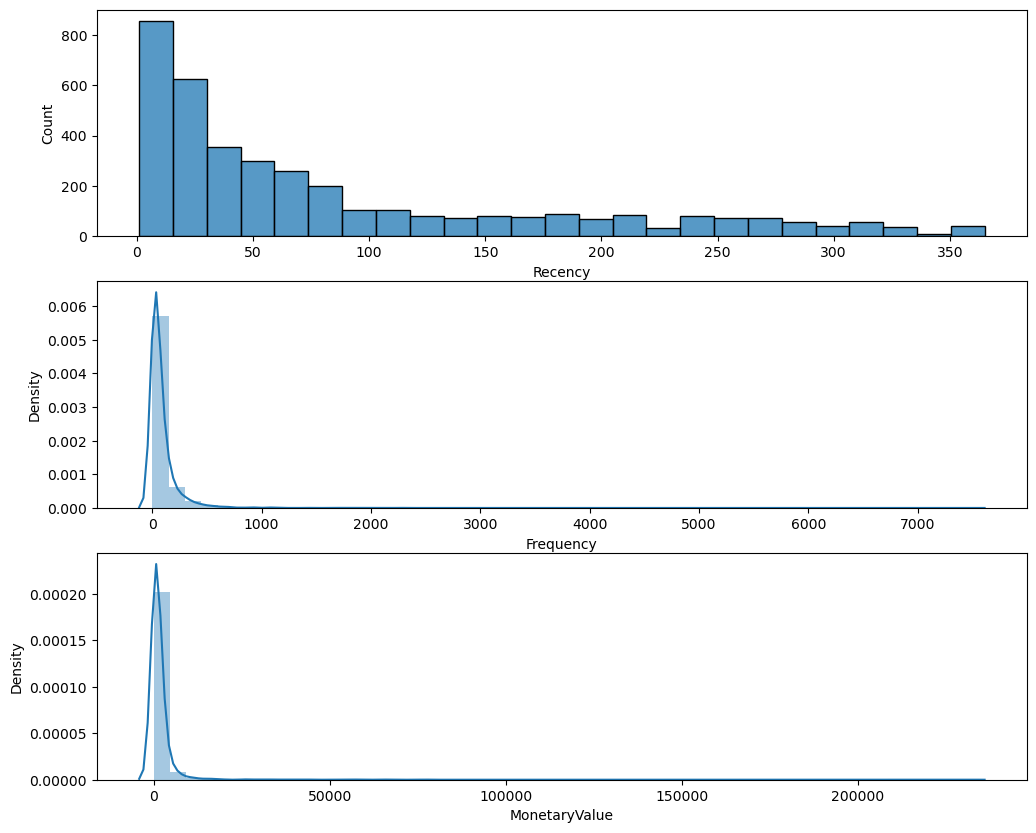

In [54]:
# Checking the distribution of Recency, Frequency and MonetaryValue variables.
plt.figure(figsize=(12,10))

# Plot distribution of var1
plt.subplot(3, 1, 1); sns.histplot(data['Recency'])

# Plot distribution of var2
plt.subplot(3, 1, 2); sns.distplot(data['Frequency'])

# Plot distribution of var3
plt.subplot(3, 1, 3); sns.distplot(data['MonetaryValue'])

As we can see from the above plots, all the variables do not have a symmetrical distribution. All of them are skewed to the right. To remove the skewness, we can try the following transformations:

1. log transformations
2. Box-Cox transformations
3. Cube root transformations

The log transformation cannot be used for negative values. One common practice one can use here is to add a constant value to get a positive value and this is generally taken as the absolute of the least negative value of the variable to each observation. However, in our data, we do not have any negative values since we are dealing with customer transactions dataset. 

In [55]:
# Checking for constant mean and variance.
data[['Recency','Frequency','MonetaryValue']].describe()

,Recency,Frequency,MonetaryValue
count,3855.000000,3855.000000,3855.000000
mean,87.428016,87.205966,1817.792603
std,93.428162,209.411865,7190.041841
min,1.000000,1.000000,0.000000
25%,17.000000,16.000000,291.680000
50%,50.000000,40.000000,638.060000
75%,134.000000,96.000000,1545.515000
max,365.000000,7491.000000,231822.690000


From the above description, we can see that the minimum MonetaryValue for a particular customerID is 0. This transaction therefore does not make any sense and needs to be removed.

We also see that we do not get constant mean and standard deviation values.

Removing the customer with 0 MonetaryValue from the data:

In [56]:
data[data['MonetaryValue'] == 0]

,CustomerID,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,General_Segment
310,13256,14,1,0.0,4,1,1,411,6,Middle


In [57]:
data = data[data['MonetaryValue'] > 0]
data.reset_index(drop=True,inplace=True)

In [58]:
raw_data = data[['Recency','Frequency','MonetaryValue']]

Let us now apply log transformation to the data and normalize it.

In [59]:
# Unskew the data
data_log = np.log(raw_data)

# Initialize a standard scaler and fit it
scaler = StandardScaler()
scaler.fit(data_log)

# Scale and center the data
data_normalized = scaler.transform(data_log)

# Create a pandas DataFrame
data_norm = pd.DataFrame(data=data_log, index=raw_data.index, columns=raw_data.columns)

In [60]:
data_norm.head()

,Recency,Frequency,MonetaryValue
0,5.786897,0.000000,11.253942
1,0.693147,4.564348,8.252563
2,0.000000,8.307706,10.344376
3,1.386294,5.293305,8.316515
4,1.098612,4.077537,6.848366


Checking for skewness in the data now:

C:\Users\USER\AppData\Local\Temp\ipykernel_34400\3663842288.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 1); sns.distplot(data_norm['Recency'])
C:\Users\USER\AppData\Local\Temp\ipykernel_34400\3663842288.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 2); sns.distplot(data_n

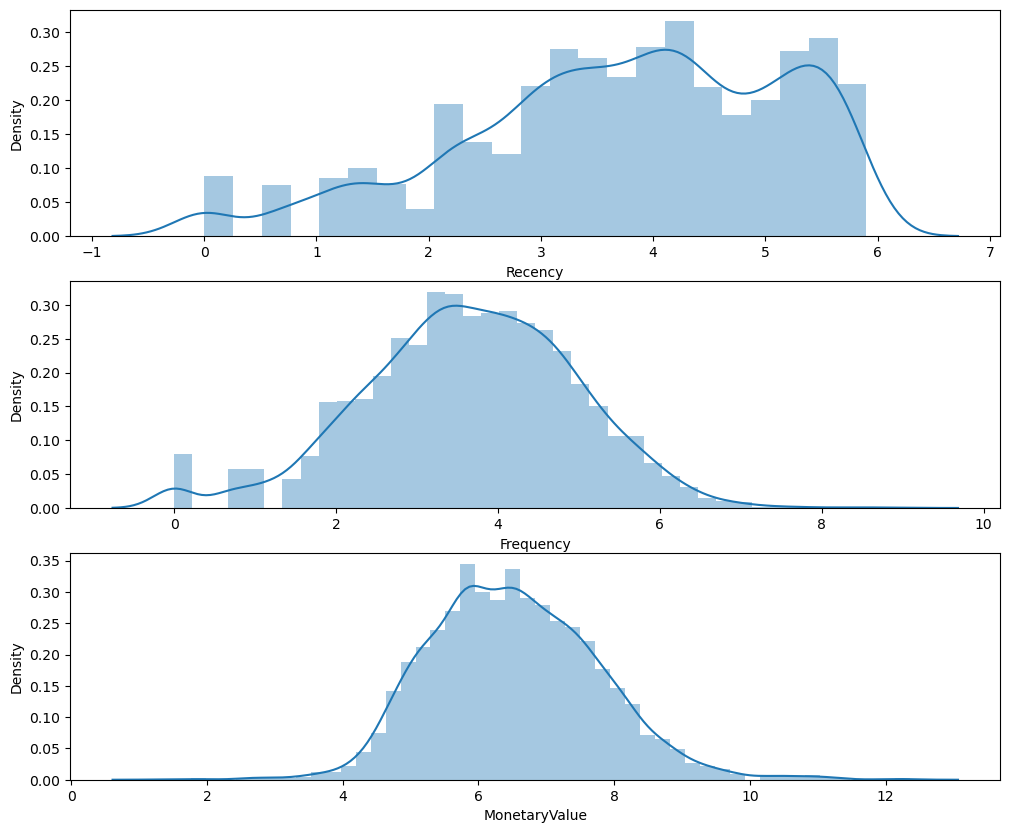

In [61]:
plt.figure(figsize=(12,10))

# Plot recency distribution
plt.subplot(3, 1, 1); sns.distplot(data_norm['Recency'])

# Plot frequency distribution
plt.subplot(3, 1, 2); sns.distplot(data_norm['Frequency'])

# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.distplot(data_norm['MonetaryValue'])

# Show the plot
plt.show()

As we can see from the above plots, skewness has been removed from the data.

##### Clustering with K-means algorithm 

In this section, we will build multiple clusters upon our RFM data (data_norm) and will try to find out the optimal number of clusters in our data using the elbow method.

In [62]:
from sklearn.cluster import KMeans

In [63]:
sse = {}

# Fit KMeans and calculate SSE for each k
for k in range(1, 21):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(data_norm)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_

C:\Users\USER\anaconda3\envs\AI\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\envs\AI\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\envs\AI\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\envs\AI\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\envs

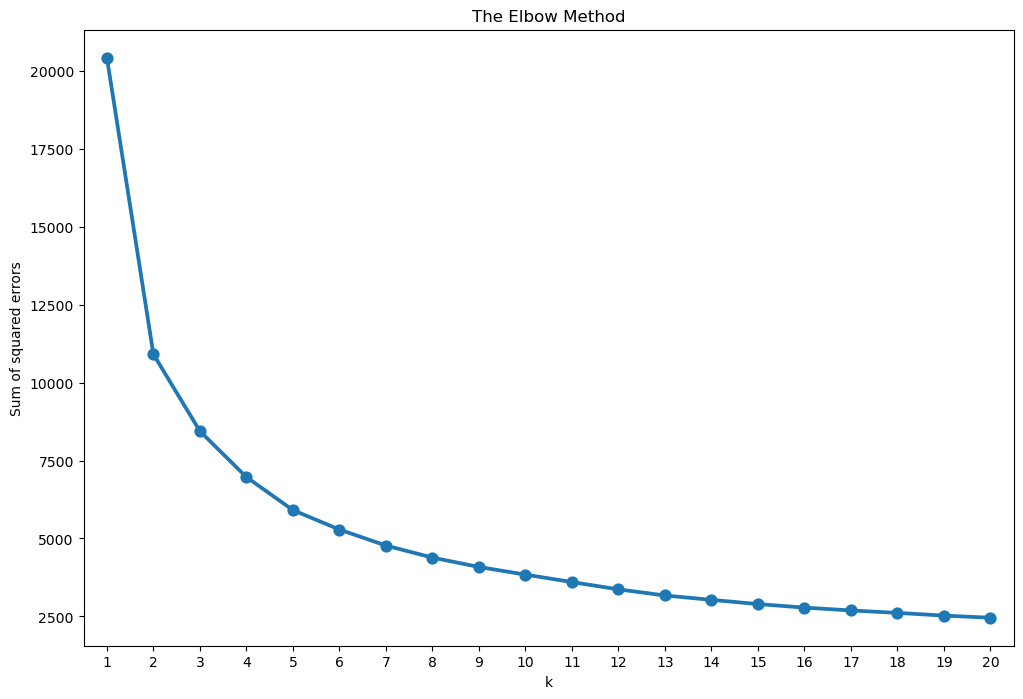

In [64]:
plt.figure(figsize=(12,8))

plt.title('The Elbow Method')
plt.xlabel('k'); 
plt.ylabel('Sum of squared errors')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

From the above plot, we can see that the optimal number of cluster is 3 or 4.

Let us take k = 3 first.

In [65]:
kmeans = KMeans(n_clusters=3, random_state=1)

# Compute k-means clustering on pre-processed data
kmeans.fit(data_norm)

# Extract cluster labels from labels_ attribute
cluster_labels = kmeans.labels_

C:\Users\USER\anaconda3\envs\AI\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [66]:
# Create a cluster label column in the original DataFrame
data_norm_k3 = data_norm.assign(Cluster = cluster_labels)
data_k3 = raw_data.assign(Cluster = cluster_labels)

# Calculate average RFM values and size for each cluster
summary_k3 = data_k3.groupby(['Cluster']).agg({'Recency': 'mean',
                                                    'Frequency': 'mean',
                                                    'MonetaryValue': ['mean', 'count'],}).round(0)

summary_k3

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          67.0      67.0        1182.0  1636
1         161.0      14.0         284.0  1357
2          11.0     240.0        5445.0   861

Let us now take k = 4.

In [67]:
kmeans = KMeans(n_clusters=4, random_state=1)

# Compute k-means clustering on pre-processed data
kmeans.fit(data_norm)

# Extract cluster labels from labels_ attribute
cluster_labels = kmeans.labels_

C:\Users\USER\anaconda3\envs\AI\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [68]:
# Create a cluster label column in the original DataFrame
data_norm_k4 = data_norm.assign(Cluster = cluster_labels)
data_k4 = raw_data.assign(Cluster = cluster_labels)

# Calculate average RFM values and size for each cluster
summary_k4 = data_k4.groupby(['Cluster']).agg({'Recency': 'mean',
                                                    'Frequency': 'mean',
                                                    'MonetaryValue': ['mean', 'count'],}).round(0)

summary_k4

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          85.0      85.0        1551.0  1147
1         178.0      15.0         293.0  1216
2          10.0     269.0        6197.0   721
3          21.0      34.0         525.0   770

##### Profiling and interpreting segments 
Results side by side

In [69]:
display(summary_k3)
display(summary_k4)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          67.0      67.0        1182.0  1636
1         161.0      14.0         284.0  1357
2          11.0     240.0        5445.0   861

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          85.0      85.0        1551.0  1147
1         178.0      15.0         293.0  1216
2          10.0     269.0        6197.0   721
3          21.0      34.0         525.0   770

We can also build snakeplots to understand and compare the segments. Let us build a snakeplot for our data with 4 clusters below. 

Before building snakeplots, let us assign back customerID values to the row indices.

In [70]:
data_norm_k4.index = data['CustomerID'].astype(int)

In [71]:
data_norm_k4.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12346,5.786897,0.000000,11.253942,0
12747,0.693147,4.564348,8.252563,2
12748,0.000000,8.307706,10.344376,2
12749,1.386294,5.293305,8.316515,2
12820,1.098612,4.077537,6.848366,2


In [72]:
# Melt the data into along format so RFM values and metric names are stored in 1 column each
data_melt = pd.melt(data_norm_k4.reset_index(),
                    id_vars=['CustomerID', 'Cluster'],
                    value_vars=['Recency', 'Frequency', 'MonetaryValue'],
                    var_name='Attribute',
                    value_name='Value')

<Axes: title={'center': 'Snake plot of standardized variables'}, xlabel='Attribute', ylabel='Value'>

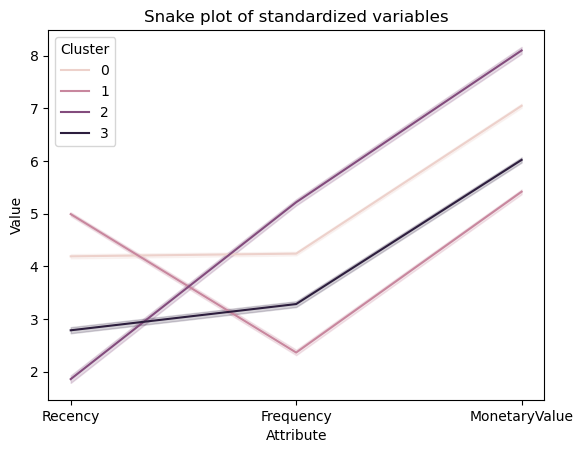

In [73]:
plt.title('Snake plot of standardized variables')
sns.lineplot(x="Attribute", y="Value", hue='Cluster', data=data_melt)

We can also use the following method to understand the relative importance of segments in the data. To do this, we will complete the following steps:
    1. Calculate average values of each cluster
    2. Calculate average values of population
    3. Calculate importance score by dividing them and subtracting 1 (ensures 0 is returned when cluster average equals population average)

Assigning CustomerID index to data_k4 dataframe:

In [74]:
data_k4.index = data['CustomerID'].astype(int)
data_k4.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12346,326,1,77183.60,0
12747,2,96,3837.45,2
12748,1,4055,31081.74,2
12749,4,199,4090.88,2
12820,3,59,942.34,2


Assigning CustomerID index to raw_data dataframe:

In [75]:
raw_data.index = data['CustomerID'].astype(int)
raw_data.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,326,1,77183.60
12747,2,96,3837.45
12748,1,4055,31081.74
12749,4,199,4090.88
12820,3,59,942.34


In [76]:
cluster_avg = data_k4.groupby(['Cluster']).mean()
population_avg = raw_data.head().mean()

In [77]:
cluster_avg

,Recency,Frequency,MonetaryValue
Cluster,,,
0,84.549259,85.401046,1550.655024
1,178.092928,14.846217,293.134425
2,9.758669,268.549237,6196.815354
3,21.358442,34.475325,525.498494


In [78]:
population_avg

Recency             67.200
Frequency          882.000
MonetaryValue    23427.202
dtype: float64

In [79]:
relative_imp = cluster_avg / population_avg - 1
relative_imp.round(2)

,Recency,Frequency,MonetaryValue
Cluster,,,
0,0.26,-0.90,-0.93
1,1.65,-0.98,-0.99
2,-0.85,-0.70,-0.74
3,-0.68,-0.96,-0.98


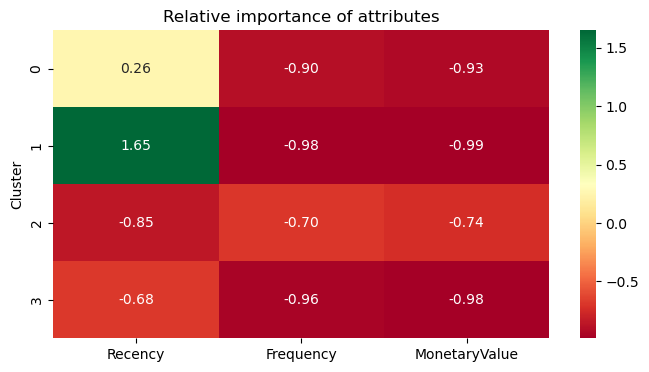

In [80]:
# Plot heatmap
plt.figure(figsize=(8, 4))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

In [81]:
import session_info
session_info.show(html=False)

-----
dateutil            2.8.2
matplotlib          3.8.0
numpy               1.26.4
pandas              2.1.4
seaborn             0.13.2
session_info        1.0.0
sklearn             1.2.2
-----
IPython             8.20.0
jupyter_client      8.6.0
jupyter_core        5.5.0
jupyterlab          4.0.11
notebook            7.0.8
-----
Python 3.11.8 | packaged by Anaconda, Inc. | (main, Feb 26 2024, 21:34:05) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.22631-SP0
-----
Session information updated at 2024-03-25 22:17
